# Import Libraries

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats.mstats import winsorize
from scipy.interpolate import griddata

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense, Dropout, MaxPool1D, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2

import pickle as pkl

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [3]:
## Recursive Feature Elimination with Cross-Validation
def rfecv(estimator, X, y, step, cv):
    rfecv = RFECV(estimator=estimator, 
                  step=step, 
                  cv=KFold(cv, 
                           shuffle=True, 
                           random_state=42),
                  scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    return rfecv

## Plotting % of Correct Classification
def plot_pcc(rfecv, title):
    
    plt.figure(figsize=(10, 9))
    plt.title(title, 
              fontsize=18, 
              fontweight='bold', 
              pad=20)
    plt.xlabel('Number of features selected', 
               fontsize=14, 
               labelpad=20)
    plt.ylabel('% Correct Classification', 
               fontsize=14, 
               labelpad=20)
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], 
             color='#303F9F', 
             linewidth=3)
    
    plt.show()

## Plotting feature importances
def feature_importance(rfecv, X, title): 
        
    df = pd.DataFrame()
    
    df['column'] = X.columns
    df['importance'] = rfecv.estimator_.feature_importances_
    
    df.sort_values(by='importance', 
                   ascending=False, 
                   inplace=True, 
                   ignore_index=True)
    
    sns.set(rc = {'figure.figsize':(8,10)})
    ax = sns.barplot(y='column', 
                     x='importance',
                     data=df,
                     palette='viridis')
    
    ax.set_title(title, 
                 fontsize=18)

## Predicting validation data
def pred_val(df, columns, sc, model):

    scaled_df = sc.transform(df)
    
    scaled_df = pd.DataFrame(scaled_df, 
                             columns=df.columns)
    
    scaled_df = scaled_df[columns]

    y_pred = model.predict(scaled_df)

    return y_pred

## Evaluate the final model
def eval_model(y, y_pred, title):
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r_squared = r2_score(y, y_pred)

    print(f'{title}')
    print(f'Mean Squared Error: {np.round(mse, 2)}')
    print(f'Root Mean Squared Error: {np.round(rmse, 2)}')
    print(f'Mean Absolute Error: {np.round(mae, 2)}')
    print(f'R-squared Error: {np.round(r_squared, 2)}')

## Plotting Learning curves
def plot_learing_curve(model, X, y, cv, model_title):

    train_sizes = [50, 100, 200, 400, 760]

    train_sizes, train_scores, validation_scores = learning_curve(model, X, y, 
                                                                  train_sizes=train_sizes, 
                                                                  cv=cv, 
                                                                  scoring='neg_mean_squared_error', 
                                                                  shuffle=True)

    train_scores_mean = -train_scores.mean(axis=1)
    validation_scores_mean = -validation_scores.mean(axis=1)

    plt.style.use('seaborn')
    plt.plot(train_sizes, 
             train_scores_mean, 
             label = 'Training error')
    plt.plot(train_sizes, 
             validation_scores_mean, 
             label = 'Validation error')
    plt.ylabel('MSE', 
               fontsize = 14)
    plt.xlabel('Training set size', 
               fontsize = 14)
    plt.title(f'Learning curves for a {model_title} model', 
              fontsize = 18, 
              y = 1.03)
    plt.legend()
    plt.ylim(0,40)

# Load Data

In [17]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [62]:
str_sed_data = pd.read_csv(data_path + '/Kodangal dataset/Kodangal_gcM.csv')

In [63]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,u,pt,pd,toposheet,in_,f,te,tl,hg,cd
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,9.414,3.312,0.543,14.668,...,1.811020,0,0,56G04,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,9.853,3.748,0.580,14.042,...,2.203597,0,0,56G04,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.910,...,2.711943,0,0,56G04,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.430,...,2.982200,0,0,56G04,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.990,...,3.249200,0,0,56G04,0.083470,300.0,0.067475,0.447018,6.0,50.0


# EDA

In [64]:
rem_elem = []
for col in str_sed_data.columns:
    if (str_sed_data[col] == 0).all():
        rem_elem.append(col)
print(f"Elements which don't contribute in the sediment composition: {rem_elem}")

Elements which don't contribute in the sediment composition: ['loi', 'pt', 'pd']


In [65]:
str_sed_data.drop(rem_elem, axis=1, inplace=True)

In [66]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,ta,w,u,toposheet,in_,f,te,tl,hg,cd
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,9.414,3.312,0.543,14.668,...,0.862203,0.991997,1.811020,56G04,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,9.853,3.748,0.580,14.042,...,0.958655,0.943758,2.203597,56G04,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.910,...,1.428838,1.682294,2.711943,56G04,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.430,...,1.542800,1.803219,2.982200,56G04,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.990,...,1.467300,1.451395,3.249200,56G04,0.083470,300.0,0.067475,0.447018,6.0,50.0


In [67]:
str_elem = []

for col in list(str_sed_data.columns):
    if col not in ['gid', 
                   'objectid', 
                   'sampleno', 
                   'longitude', 
                   'latitude', 
                   'toposheet']:
        str_elem.append(col)

In [68]:
len(str_elem)

62

In [69]:
elem_df = str_sed_data[str_elem]
elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,44.750,9.414,3.312,0.543,14.668,1.573,0.073,0.152,1.258,0.129,...,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,45.129,9.853,3.748,0.580,14.042,1.480,0.109,0.167,1.207,0.080,...,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,58.283,12.534,7.768,1.321,2.910,1.912,0.192,0.050,0.800,0.061,...,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,61.180,11.670,8.340,1.420,2.430,1.710,0.180,0.250,0.660,0.080,...,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,60.300,11.470,8.270,1.430,1.990,1.610,0.170,0.230,0.580,0.060,...,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,6.0,50.0


In [70]:
zero_count_features = (elem_df == 0).sum()
df = zero_count_features[zero_count_features > 300]
df

au     392
li     392
cs     486
as_    578
sb     578
bi     578
se     578
ag     392
mo     486
w      485
in_    588
f      588
te     588
tl     588
dtype: int64

In [71]:
elem_df = elem_df.head(588)
elem_df.tail(5)

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,hf,ta,w,u,in_,f,te,tl,hg,cd
583,40.35,14.12,18.56,5.72,0.99,0.92,0.24,0.29,0.31,0.24,...,9.293523,2.304848,0.862960,1.990782,0.187086,276.0,0.091641,0.237900,27.0,50.0
584,46.83,20.08,12.71,2.34,0.68,0.68,0.25,0.20,1.07,0.17,...,10.184300,1.610289,2.937731,3.614382,0.137180,270.0,0.093281,0.705034,31.0,50.0
585,46.42,20.28,13.18,2.42,0.57,0.64,0.27,0.16,1.04,0.17,...,12.118209,1.693362,2.722033,3.865095,0.149293,329.0,0.118909,0.763413,33.0,50.0
586,42.12,15.07,17.11,4.32,2.72,1.16,0.22,0.33,0.29,0.16,...,5.680000,0.760000,0.576405,0.930000,0.111583,185.0,0.077013,0.141977,10.0,50.0
587,45.52,9.98,11.58,2.62,8.89,2.24,0.21,0.37,0.34,0.17,...,4.920000,0.360000,0.250000,0.880000,0.089209,186.0,0.062873,0.126050,16.0,50.0


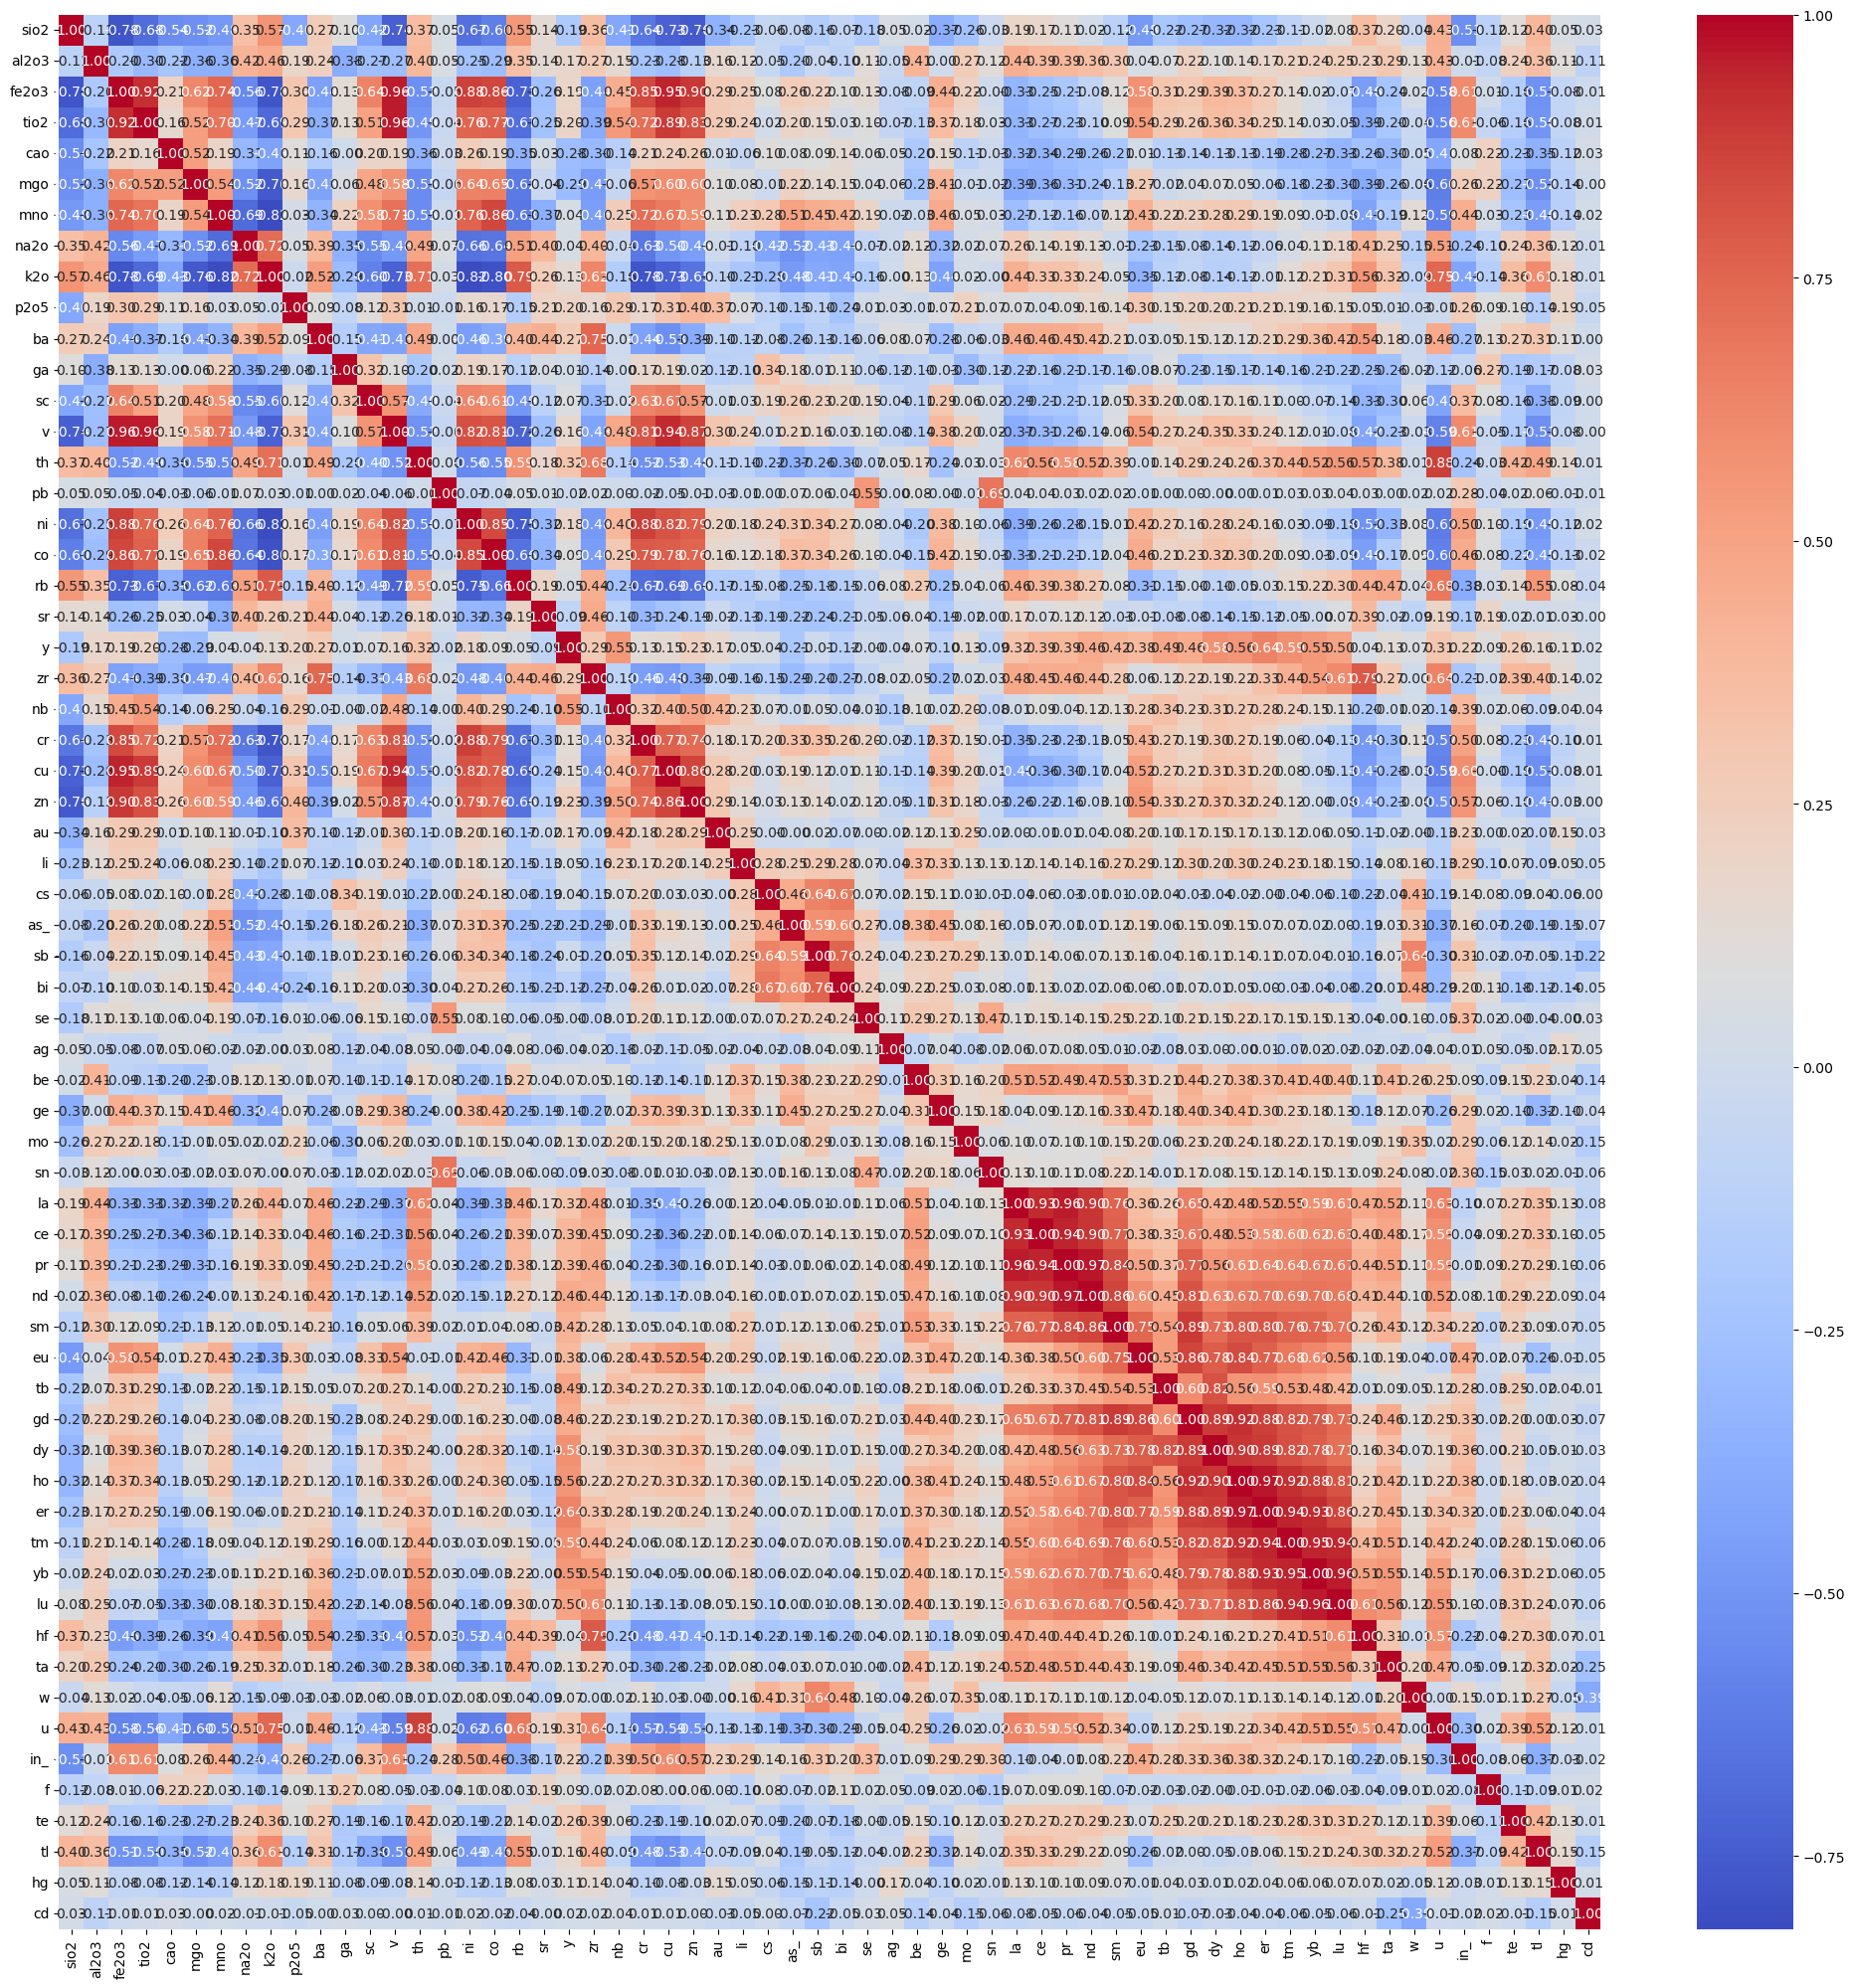

In [100]:
plt.figure(figsize=(25,25))
sns.heatmap(elem_df.corr(), 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')
plt.show()

### Histogram plots

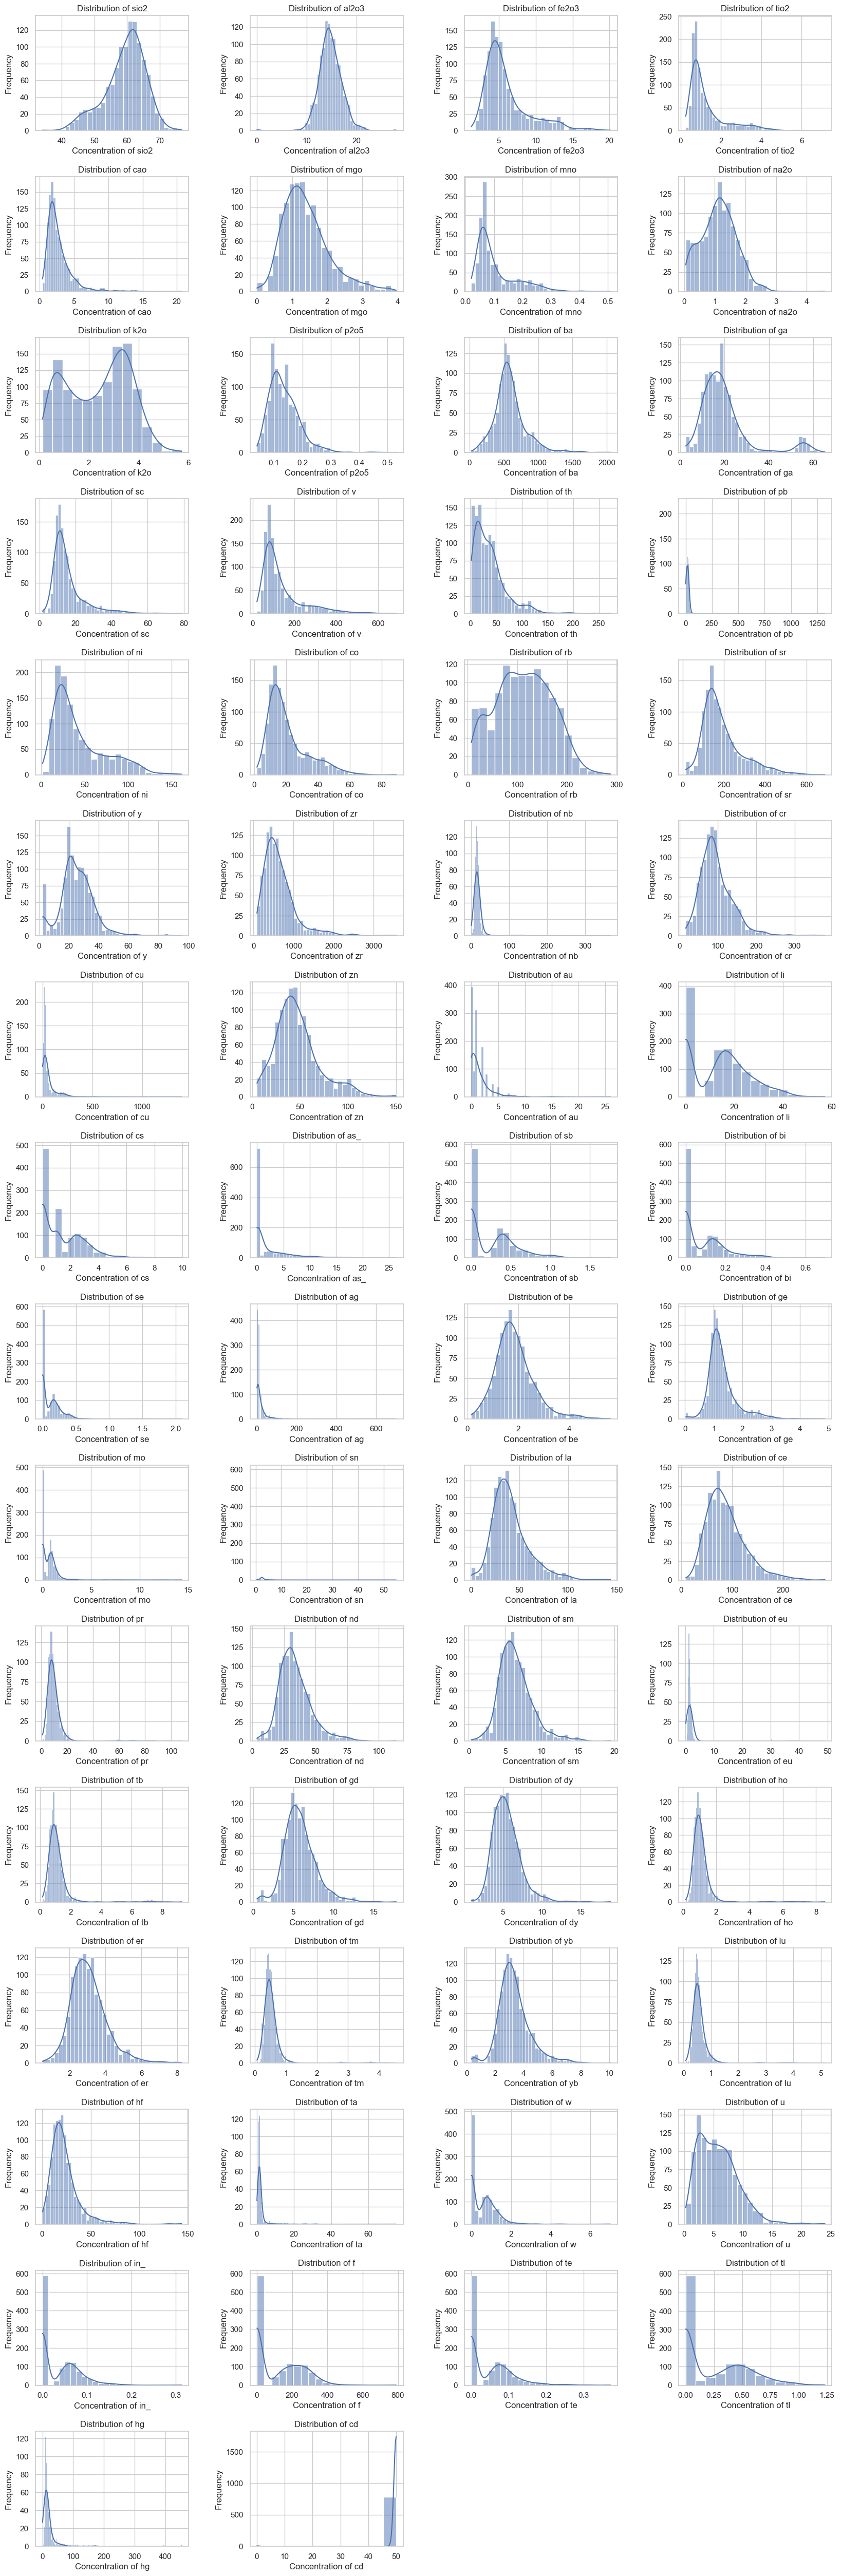

In [13]:
num_elem = len(str_elem)
num_cols = 4
num_rows = (num_elem + num_cols - 1)//num_cols 

sns.set(style='whitegrid')

fig, axes = plt.subplots(num_rows, 
                         num_cols, 
                         figsize=(num_cols*5, num_rows*4))

fig.subplots_adjust(hspace=0.4, 
                    wspace=0.4)

for i, elem in enumerate(str_elem):

    ax = axes[i // num_cols, i % num_cols]  # Determine the position in the grid
    sns.histplot(elem_df[elem], 
                 kde=True, 
                 ax=ax)
    ax.set_title(f'Distribution of {elem}')
    ax.set_xlabel(f'Concentration of {elem}')
    ax.set_ylabel('Frequency')

# If there are any empty subplots in the grid, hide them
for j in range(i + 1, num_rows * num_cols):
    axes[j // num_cols, j % num_cols].axis('off')

plt.show()

## Boxplots

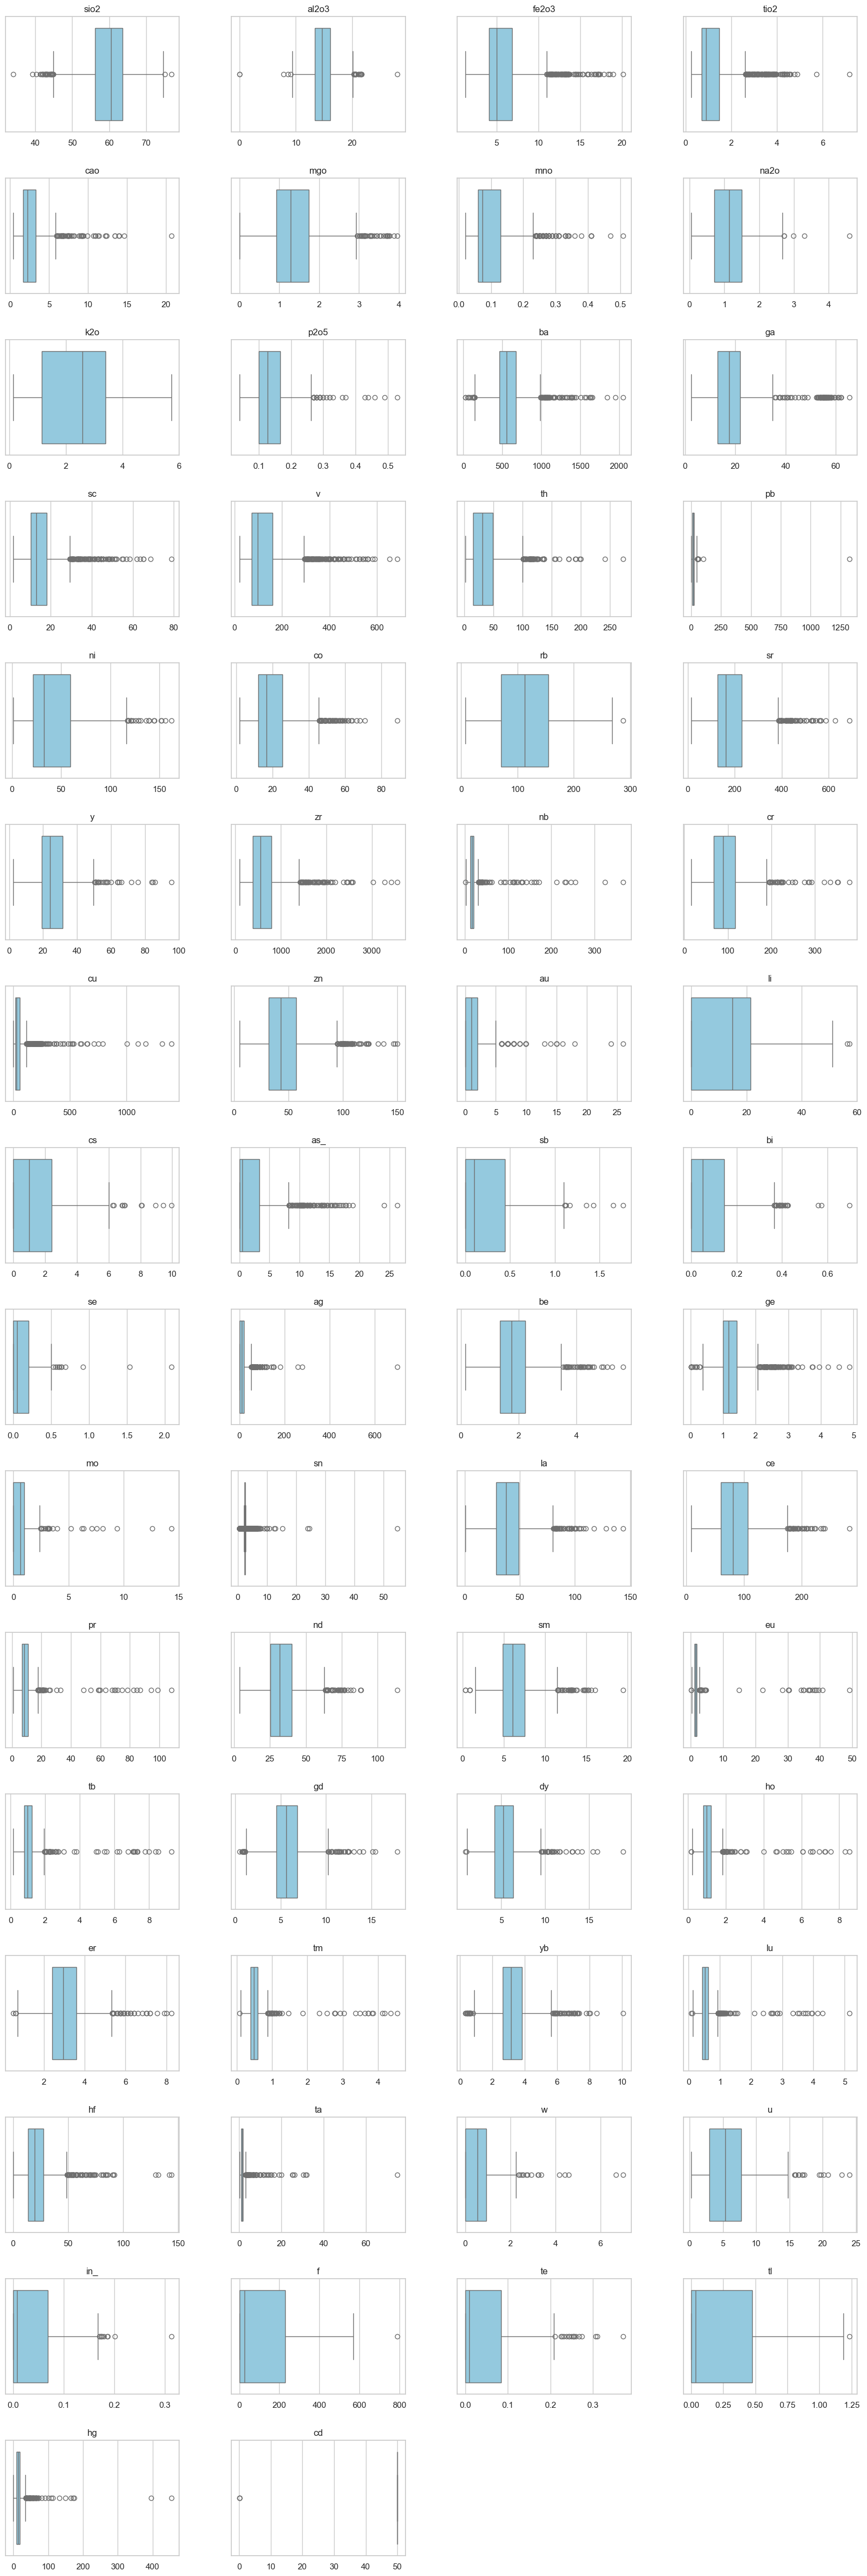

In [14]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+4-1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_elem, axes.flatten())):
    sns.boxplot(x=elem_df[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+4-1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

### Drop elements based on certain condition

- Elements having concentration values less than 1

In [72]:
drop_elem = ['mno', 'p2o5', 'sb', 'bi', 'se', 'in_', 'te', 'tl']

In [73]:
elem_df.drop(drop_elem, axis=1, inplace=True)

- Elements having same almost same values at each sample

In [74]:
elem_df.drop(['cd'], axis=1, inplace=True)

## Handling outliers

In [75]:
def handle_outl(df):

    cols = list(df.columns)
    
    for elem in cols:
        
        Q1 = df[elem].quantile(0.25)
        Q3 = df[elem].quantile(0.75)
        IQR = Q3 - Q1
        lwr_bnd = Q1 - (1.5 * IQR)
        upr_bnd = Q3 + (1.5 * IQR)

        quantiles = {
            87 : df[elem].quantile(0.87), 
            90 : df[elem].quantile(0.90),
            92.5 : df[elem].quantile(0.925),
            95 : df[elem].quantile(0.95),
            97.5 : df[elem].quantile(0.975),
            99 : df[elem].quantile(0.99)
        }
        
        min_diff = float('inf')
        nearest_key = None
        for key, val in quantiles.items():
        
            if val >= upr_bnd:
                diff = val - upr_bnd
                if diff < min_diff:
                    min_diff = diff
                    nearest_key = key
        
        if nearest_key is None:
            df[elem] = df[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)
            continue
        
        nearest_key = (100 - nearest_key) / 100
        nearest_key = np.round(nearest_key, 3)
        df[elem] = winsorize(df[elem], limits=(0.05, nearest_key))

    return df

In [76]:
elem_outl_df = handle_outl(elem_df)

### After handling outliers

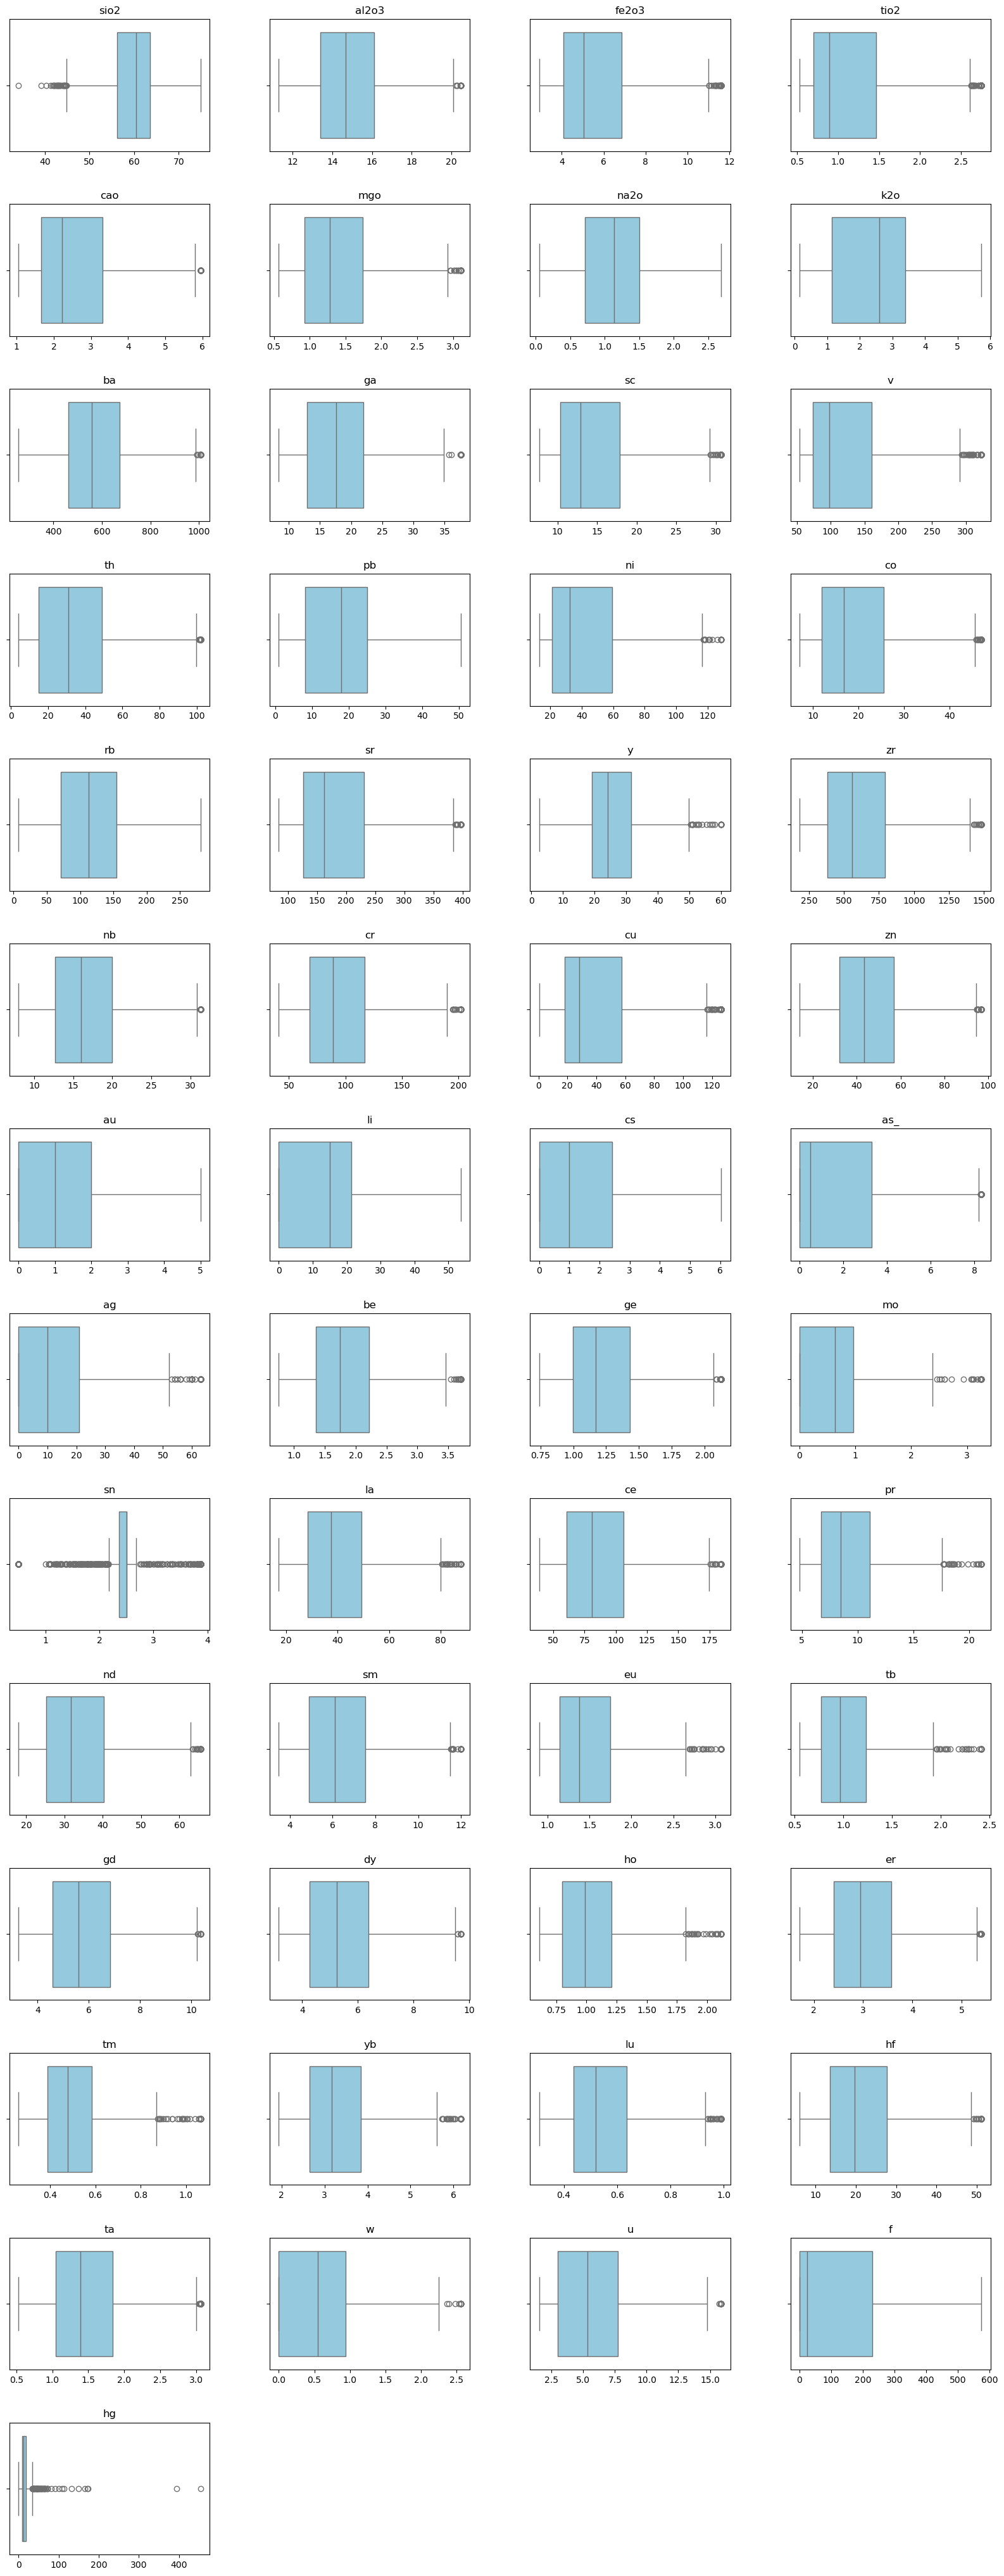

In [17]:
n_elem = len(elem_outl_df.columns)

fig, axes = plt.subplots(nrows=(n_elem+4-1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(elem_outl_df.columns, axes.flatten())):
    sns.boxplot(x=elem_outl_df[elem_outl_df.columns][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+4-1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

# Normalize

In [77]:
train_df = elem_outl_df.copy()
target = elem_outl_df['au']
train_df.drop(['au'], axis=1, inplace=True)

In [78]:
train_df.shape

(588, 52)

In [79]:
# sc = StandardScaler()

# norm_data = sc.fit_transform(train_df)

min_max = MinMaxScaler()
norm_data = min_max.fit_transform(train_df)

# train_df_norm = pd.DataFrame(norm_data, 
#                             index=train_df.index, 
#                             columns=train_df.columns)

In [80]:
n_samples = len(train_df)
n_features = len(train_df.columns)
train_df = norm_data.reshape((n_samples, n_features, 1))
train_df.shape

(588, 52, 1)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(train_df, 
                                                    target, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True)

In [82]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1, 
                                                  random_state=42,
                                                  shuffle=True)

# Model Training

## CNN

In [102]:
def cnn_model(n_features, learning_rate):
    
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, padding='same', input_shape=(n_features, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Dropout(0.5))
    # model.add(GlobalAveragePooling1D())

    model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Dropout(0.3))

    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Dropout(0.3))

    model.add(Conv1D(512, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))

    opt = Adam(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    return model

In [103]:
model = cnn_model(n_features, 0.001)
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)                   │ (None, 52, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 52, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_40 (MaxPooling1D)      │ (None, 26, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 26, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 26, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 26, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_41 (MaxPooling1D)      │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_42 (Conv1D)                   │ (None, 13, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 13, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_42 (MaxPooling1D)      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 6, 512)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 6, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_43 (MaxPooling1D)      │ (None, 3, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 3, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 3, 32)               │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 3, 64)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 3, 128)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 258,081 (1008.13 KB)

 Trainable params: 256,609 (1002.38 KB)

 Non-trainable params: 1,472 (5.75 KB)

In [104]:
cnnmodel = model.fit(X_train, y_train, 
                     epochs=100, batch_size=32, 
                     validation_data=(X_val, y_val))

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 5.2262 - val_loss: 4.0301
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5431 - val_loss: 3.2833
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3607 - val_loss: 2.8402
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3114 - val_loss: 2.6138
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3121 - val_loss: 2.4593
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2841 - val_loss: 2.3509
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1615 - val_loss: 1.9792
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1499 - val_loss: 1.8725
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1925 - val_loss: 1.7827
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1474 - val_loss: 1.5863
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1872 - val_loss: 1.3828
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

In [91]:
def metrics_graph(model, num_epoch):
    
    r_ep = range(num_epoch)
    train_loss = model.history['loss']
    validation_loss = model.history['val_loss']

    plt.figure(figsize=(15,7))
    
    plt.subplot(1, 2, 1)
    plt.title('Train vs Validation')
    plt.plot(r_ep, train_loss)
    plt.plot(r_ep, validation_loss)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')

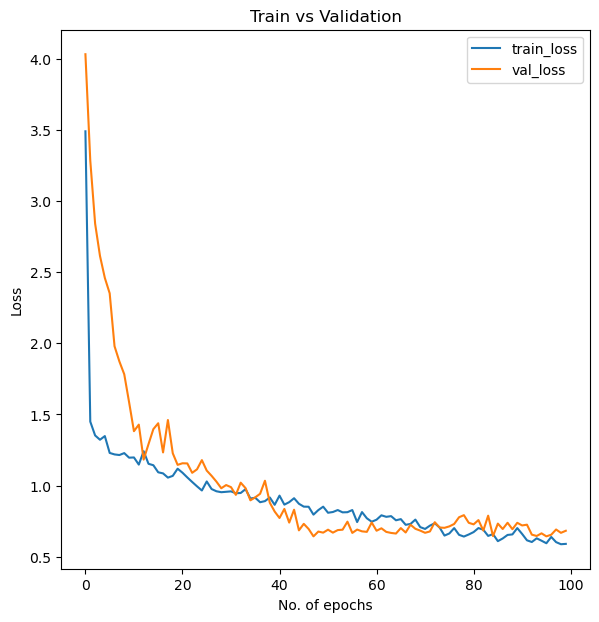

In [105]:
metrics_graph(cnnmodel, 100)